In [ ]:
#!pip install yfinance

     |████████████████████████████████| 5.5MB 10.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=a4705f9f91b722684d6b46b76b84aa6d1a216b97f49149cc3fb74dd88daf9c7b
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
#import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack
import random
import requests
import io
%matplotlib inline

In [59]:
df = pd.read_csv('/content/BTC_USC_2Y.csv') #minute by minute

In [60]:
print(df)
len(df)
df_val = ((df['High']+df['Low'])/2)

          Timestamp      Open  ...  Volume_(Currency)  Weighted_Price
0        1537008360   6520.99  ...         440.075858     6520.228681
1        1537008420   6520.21  ...         922.682336     6520.429228
2        1537008480   6521.00  ...        1937.535366     6521.000000
3        1537008540   6525.73  ...          52.180892     6525.874437
4        1537008600   6525.51  ...          79.093580     6520.686493
...             ...       ...  ...                ...             ...
1050550  1600041360  10324.35  ...         837.754188    10324.419779
1050551  1600041420  10331.41  ...        5918.028741    10331.444396
1050552  1600041480  10327.20  ...       25711.238323    10326.175283
1050553  1600041540  10330.02  ...       47253.747619    10333.972651
1050554  1600041600  10338.82  ...       13349.565122    10332.429402

[1050555 rows x 8 columns]


In [61]:

print(df_val[:1])
print(df_val[-1:])

print(df_val[-1:].values/df_val[:1].values)

0    6520.6
dtype: float64
1050554    10335.595
dtype: float64
[1.58506809]


In [ ]:
#Naive version 1

ARB = 0.001
LOOK_BACK_TIME_MIN = 15
DROP_TO_BUY =  2 * ARB

profit = 1.0
position = 'buy'


for i in range(LOOK_BACK_TIME_MIN+1,len(df_val)):
  max_val = df_val[i-LOOK_BACK_TIME_MIN:i-1].mean()
  current_val = df_val[i]


  if position == 'buy':
    # check stats
    if df_val[i-60*24:i].diff().dropna().mean() > 0:
      if 1-current_val/max_val > DROP_TO_BUY:
        position = 'sell'
        buy_value = current_val
      
  
  if position == 'sell':
    if current_val/buy_value-1 > ARB:
        profit *= current_val/buy_value
        position = 'buy'
    if 1-current_val/buy_value > 10*ARB:
        profit *= current_val/buy_value
        position = 'buy'
    

  if i % (60 * 24) == 0:
    print('day ' , i / (60 * 24), ' profit = ', profit)

print('total profit = ', profit)

day  1.0  profit =  1.0
day  2.0  profit =  1.0169706938954841
day  3.0  profit =  1.006051193622809
day  4.0  profit =  0.9874001831431064
day  5.0  profit =  0.9682544309272129
day  6.0  profit =  0.9709828226724269
day  7.0  profit =  0.961238187837241
day  8.0  profit =  0.9513141566389117
day  9.0  profit =  0.9558437512971755
day  10.0  profit =  0.9558437512971755
day  11.0  profit =  0.9701154233070464
day  12.0  profit =  0.959809354238716
day  13.0  profit =  0.9619727039323401
day  14.0  profit =  0.952326812823715
day  15.0  profit =  0.952326812823715
day  16.0  profit =  0.9545450305059037
day  17.0  profit =  0.9545450305059037
day  18.0  profit =  0.9545450305059037
day  19.0  profit =  0.9673925084900915
day  20.0  profit =  0.9673925084900915
day  21.0  profit =  0.9689358994361958
day  22.0  profit =  0.9754097826458872
day  23.0  profit =  0.9754097826458872
day  24.0  profit =  0.9754097826458872
day  25.0  profit =  0.969217403592227
day  26.0  profit =  0.9750346

KeyboardInterrupt: ignored

In [164]:
ARB = 0.01
LOOK_BACK_TIME_MIN = 60 * 1
DROP_TO_BUY =  2 * ARB
DROP_TO_SELL = 1 * ARB
PRICE_COUNT_LIMIT_BUY = 10


# interesting run 1:
#ARB = 0.001
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# and *without* the sell min with profit!

# interesting run 2:
#ARB = 0.001
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# and *with* the sell min with profit! ~40% profit in a year

# interesting run 3:
#ARB = 0.01
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# 83% profit / year

acc_change = 1.0
profit = 1.0
position = 'buy'

buy_inx = []
sell_prof_inx = []
sell_loss_inx = []

for i in range(LOOK_BACK_TIME_MIN+1,len(df_val)-5):
  #max_val = df_val[i-LOOK_BACK_TIME_MIN:i-1].mean()
  current_val = df_val[i]
  next_val = df_val.iloc[i+5]

  if not pd.notna(next_val):
    continue
  
  if pd.notna(current_val) and pd.notna(next_val):
    acc_change *= next_val/current_val

  if position == 'buy':
    # check stats
    a = df_val[i-LOOK_BACK_TIME_MIN:i]
    cnt = a[current_val > (1+ARB)*df_val[i-LOOK_BACK_TIME_MIN:i]].count()
    #if (cnt>0): print(cnt)

    if cnt > max(PRICE_COUNT_LIMIT_BUY, min(15,PRICE_COUNT_LIMIT_BUY*(profit**1.0))) and cnt < 50:
      buy_value = next_val
      buy_inx.append(df_val.keys()[i+5])
      I = i+5
      position = 'sell'
  
  if position == 'sell' and I < i:
    if current_val/buy_value-1 > ARB:
        profit *= next_val/buy_value
        sell_prof_inx.append(df_val.keys()[i+5])
        position = 'buy'
    elif 1-current_val/buy_value > min(DROP_TO_SELL, (profit**(-0.01))*DROP_TO_SELL):
        profit *= next_val/buy_value
        sell_loss_inx.append(df_val.keys()[i+5])
        position = 'buy'
    

  if i % (60 * 24) == 0:
    print('day ' , i / (60 * 24), ' profit = ', profit, '     [acc  change = ', acc_change,']')

print('total profit = ', profit)

day  1.0  profit =  1.0      [acc  change =  0.9939160293121471 ]
day  2.0  profit =  1.0      [acc  change =  0.9849057422030393 ]
day  3.0  profit =  1.0      [acc  change =  0.982924245970254 ]
day  4.0  profit =  1.0      [acc  change =  0.9702746723498347 ]
day  5.0  profit =  1.0      [acc  change =  0.9674408389655771 ]
day  6.0  profit =  1.0      [acc  change =  0.9623902545669065 ]
day  7.0  profit =  1.0      [acc  change =  0.9472084578570514 ]
day  8.0  profit =  1.0      [acc  change =  0.954468989586892 ]
day  9.0  profit =  1.0      [acc  change =  0.9337417035019967 ]
day  10.0  profit =  1.0      [acc  change =  0.9354330417290162 ]
day  11.0  profit =  1.0      [acc  change =  0.9316695370574914 ]
day  12.0  profit =  1.0      [acc  change =  0.9106743944732157 ]
day  13.0  profit =  1.0      [acc  change =  0.9266765960803486 ]
day  14.0  profit =  1.0      [acc  change =  0.8983175346683012 ]
day  15.0  profit =  1.0      [acc  change =  0.9042780508977999 ]
day  1

KeyboardInterrupt: ignored

In [118]:
ARB = 0.005
LOOK_BACK_TIME_MIN = 60 * 6
DROP_TO_BUY =  2 * ARB
DROP_TO_SELL = 6 * ARB
PRICE_COUNT_LIMIT_BUY = 10

# interesting run 1:
#ARB = 0.001
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# and *without* the sell min with profit!

# interesting run 2:
#ARB = 0.001
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# and *with* the sell min with profit! ~40% profit in a year

# interesting run 3:
#ARB = 0.01
#LOOK_BACK_TIME_MIN = 60 * 1
#DROP_TO_BUY =  2 * ARB
#DROP_TO_SELL = 1 * ARB
#PRICE_COUNT_LIMIT_BUY = 10
# 83% profit / year

acc_change = 1.0
profit = 1.0
position = 'buy'

buy_inx = []
sell_prof_inx = []
sell_loss_inx = []

for i in range(LOOK_BACK_TIME_MIN+1,len(df_val)-5):
  #max_val = df_val[i-LOOK_BACK_TIME_MIN:i-1].mean()
  current_val = df_val[i]
  next_val = df_val.iloc[i+5]

  if not pd.notna(next_val):
    continue
  
  if pd.notna(current_val) and pd.notna(next_val):
    acc_change *= next_val/current_val

  if position == 'buy':
    # check stats
    a = df_val[i-LOOK_BACK_TIME_MIN:i]
    cnt = a[(1+ARB)*current_val < df_val[i-LOOK_BACK_TIME_MIN:i]].count()
    #if (cnt>0): print(cnt)

    if cnt > max(PRICE_COUNT_LIMIT_BUY, min(15,PRICE_COUNT_LIMIT_BUY*(profit**1.0))) and cnt < 50:
      buy_value = next_val
      buy_inx.append(df_val.keys()[i+5])
      I = i+5
      position = 'sell'
  
  if position == 'sell' and I < i:
    if current_val/buy_value-1 > ARB:
        profit *= next_val/buy_value
        sell_prof_inx.append(df_val.keys()[i+5])
        position = 'buy'
    elif 1-current_val/buy_value > min(DROP_TO_SELL, (profit**(-0.01))*DROP_TO_SELL):
        profit *= next_val/buy_value
        sell_loss_inx.append(df_val.keys()[i+5])
        position = 'buy'
    

  if i % (60 * 24) == 0:
    print('day ' , i / (60 * 24), ' profit = ', profit, '     [acc  change = ', acc_change,']')

print('total profit = ', profit)

day  1.0  profit =  1.0      [acc  change =  0.9877858628189032 ]
day  2.0  profit =  1.0      [acc  change =  0.9889889983117803 ]
day  3.0  profit =  0.9728187134145129      [acc  change =  0.8382436665197214 ]
day  4.0  profit =  0.9805264583595767      [acc  change =  0.9113018989319542 ]
day  5.0  profit =  0.954114901462656      [acc  change =  0.9824648171093755 ]
day  6.0  profit =  0.9758152014905056      [acc  change =  1.2406919343577276 ]
day  7.0  profit =  0.9901838517300761      [acc  change =  1.2481847335425686 ]
day  8.0  profit =  0.9901838517300761      [acc  change =  1.3051841545174978 ]
day  9.0  profit =  0.9901838517300761      [acc  change =  1.2234033598601086 ]
day  10.0  profit =  0.959743503839659      [acc  change =  1.0601076657340718 ]
day  11.0  profit =  0.959743503839659      [acc  change =  1.1264258586874003 ]
day  12.0  profit =  0.9697578552516608      [acc  change =  1.14613022590214 ]
day  13.0  profit =  0.9929720156399585      [acc  change = 

KeyboardInterrupt: ignored

In [ ]:
I=200000

c_val = df_val[I]
a = df_val[I-60*3:I]
print(c_val > df_val[I-60*3:I])
a[c_val > df_val[I-60*3:I]].count()


199820    False
199821    False
199822    False
199823    False
199824    False
          ...  
199995    False
199996    False
199997    False
199998     True
199999    False
Length: 180, dtype: bool


106

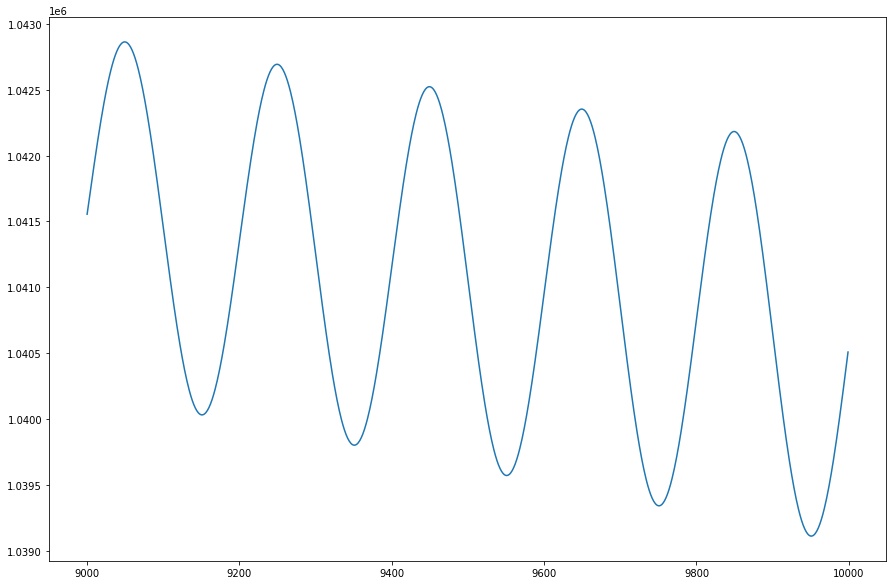

In [169]:
import math
for i in range(len(df_val)):
  df_val[i] = -i + 0.15*i*math.sin(2*i*math.pi/(100)) + len(df_val)

fig1 = plt.figure(figsize=(15,10))
plt.plot(df_val[9000:10000])

(900000.0, 1000000.0)

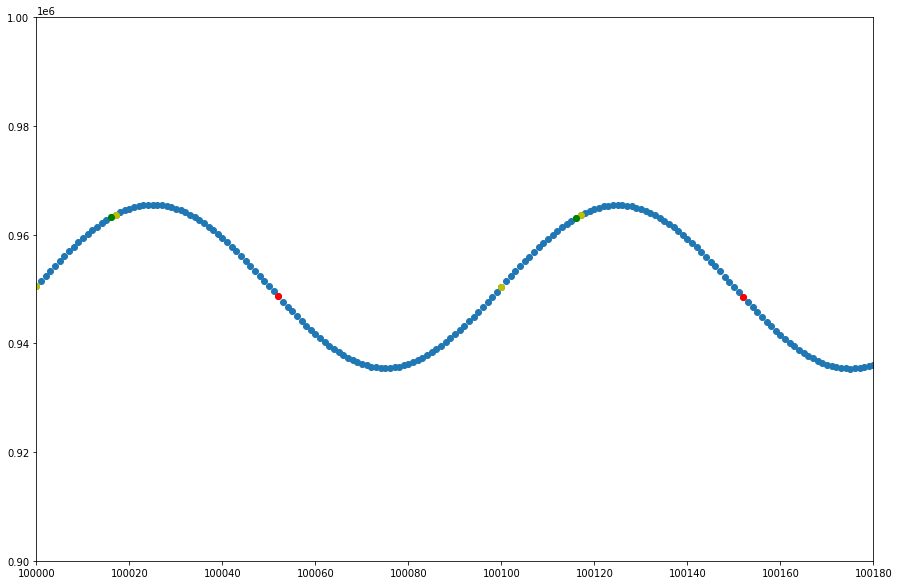

In [168]:
fig1 = plt.figure(figsize=(15,10))
plt.scatter(np.arange(len(df_val)), df_val)
plt.scatter(buy_inx,df_val[buy_inx], c='y')
plt.scatter(sell_loss_inx,df_val[sell_loss_inx], c='r')
plt.scatter(sell_prof_inx,df_val[sell_prof_inx], c='g')
plt.xlim([100000,100180])
plt.ylim([0.9*1e6,1*1e6])

In [115]:
a = df_val[8432:8492]
current_val = df_val[8492]
cnt = a[current_val > (1+ARB)*df_val[8432:8492]].count()
print(a)

8432    6557.825
8433    6557.745
8434    6555.785
8435    6553.860
8436    6554.845
8437    6554.945
8438    6555.990
8439    6555.995
8440    6557.430
8441    6557.820
8442    6557.825
8443    6565.495
8444    6569.915
8445    6571.040
8446    6567.780
8447    6572.885
8448    6567.915
8449    6564.100
8450    6568.055
8451    6570.410
8452    6584.320
8453    6619.130
8454    6646.390
8455    6646.820
8456    6619.690
8457    6626.430
8458    6634.545
8459    6640.510
8460    6635.605
8461    6631.605
8462    6636.465
8463    6637.260
8464    6638.870
8465    6644.710
8466    6645.565
8467    6640.810
8468    6644.600
8469    6645.810
8470    6643.210
8471    6641.640
8472    6640.970
8473    6642.930
8474    6645.865
8475    6649.985
8476    6655.980
8477    6666.275
8478    6678.950
8479    6680.620
8480    6681.185
8481    6690.485
8482    6712.170
8483    6712.895
8484    6715.110
8485    6728.940
8486    6732.720
8487    6719.455
8488    6710.000
8489    6719.045
8490    6720.3

In [ ]:
def StockStatsCheck(df):

  dfMean = (df['High']+df['Low'])/2

  meanArrSer =  dfMean.groupby(pd.Grouper(freq='1d')).mean().dropna()
  stdArrSer  =  dfMean.groupby(pd.Grouper(freq='1d')).std().dropna()
  #print('groups = ',meanArrSer)
  #print(meanArr)
  #print(stdArr)

  meanArr = np.array(meanArrSer.values)
  stdArr = np.array(stdArrSer.values)

  #print(abs(1-meanArr[:-1]/meanArr[1:]))
  #print(abs(1-meanArr[:-1]/meanArr[1:]) < MEAN_FLUCT * ARB_VAL)
  #print(stdArr/meanArr)
  #print(stdArr/meanArr >  STD_TO_ARB * ARB_VAL)

  c1_mean_val = np.abs(1-meanArr[:-1]/meanArr[1:])
  c2_std_val = (STD_TO_ARB*stdArr)/meanArr

  #print(c1_mean_val)

  c1_mean = c1_mean_val < MEAN_FLUCT * ARB_VAL
  c2_std = c2_std_val > ARB_VAL

  #print(c1,c2)
  c_tot = all(c1_mean) and all(c2_std) and (len(c1_mean)>0) and (len(c2_std)>0)
  if (c_tot): print (c1_mean,c2_std)
  return c_tot,c1_mean_val,c2_std_val

In [ ]:
#### Initialization ###

ARB_VAL = 0.005
MEAN_FLUCT = 0.5
STD_TO_ARB = 3

#tickers = list(pd.read_csv('/content/Nasdaq100_TickersOnly.csv')['Ticker'])
#print(tickers)

url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
print(companies)
#tickers = random.sample(companies['Symbol'].tolist(),300)
tickers = companies['Symbol'].tolist()
print(tickers)
# tickers = ["LBTYA"]
start = '2020-09-26'
end = '2020-11-21'

SCAN_WIN_DAYS = 2

startDT = pd.to_datetime(start)
endDT = pd.to_datetime(end)

startDT = startDT.tz_localize(tz='America/New_York')
endDT = endDT.tz_localize(tz='America/New_York')

DEL_T = pd.Timedelta(days=SCAN_WIN_DAYS)
ONE_DAY = pd.Timedelta(days=1)
tmpDT = startDT

     Symbol  ... Round Lot Size
0      AAIT  ...          100.0
1       AAL  ...          100.0
2      AAME  ...          100.0
3      AAOI  ...          100.0
4      AAON  ...          100.0
...     ...  ...            ...
2962     ZN  ...          100.0
2963   ZNGA  ...          100.0
2964   ZSPH  ...          100.0
2965     ZU  ...          100.0
2966   ZUMZ  ...          100.0

[2967 rows x 7 columns]
['AAIT', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPL', 'AAVL', 'AAWW', 'AAXJ', 'ABAC', 'ABAX', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABGB', 'ABIO', 'ABMD', 'ABTL', 'ABY', 'ACAD', 'ACAS', 'ACAT', 'ACET', 'ACFC', 'ACFN', 'ACGL', 'ACHC', 'ACHN', 'ACIW', 'ACLS', 'ACNB', 'ACOR', 'ACPW', 'ACRX', 'ACSF', 'ACST', 'ACTA', 'ACTG', 'ACTS', 'ACUR', 'ACWI', 'ACWX', 'ACXM', 'ADAT', 'ADBE', 'ADEP', 'ADES', 'ADHD', 'ADI', 'ADMA', 'ADMP', 'ADMS', 'ADNC', 'ADP', 'ADRA', 'ADRD', 'ADRE', 'ADRU', 'ADSK', 'ADTN', 'ADUS', 'ADVS', 'ADXS', 'ADXSW', 'AEGN', 'AEGR', 'AEHR', 'AEIS', 'AEPI', 'AERI', 'AETI', 'AEY', 'A

In [ ]:
#### Find Best Stocks to Trade ###

# This ugly code should be fixed...
df = yf.download('MSFT', start , end ,interval='2m',progress=False)
days = sorted(set(df.index.date))
days = [x.strftime('%Y-%m-%d') for x in days]
# good_tcks = {i:[] for i in range(len(days))}
good_tcks = {day:[] for day in days}
print(good_tcks.keys())
for tck in tickers:
  df = yf.download(tck, start , end ,interval='2m',progress=False)
  if (not df.empty):
    days = sorted(set(df.index.date))
    days = [x.strftime('%Y-%m-%d') for x in days]
    df['date'] = df.index
    df['date'] = df['date'].apply(lambda x:x.strftime('%Y-%m-%d') )
    # while (tmpDT + DEL_T <= endDT):
    for i in range(len(days)-SCAN_WIN_DAYS-1):
      rel_days = '|'.join(days[i:i+SCAN_WIN_DAYS])
      df_new = df[df['date'].str.contains(rel_days)]
      
      ### Find "good" stocks
      if len(df_new)>3:
        c_tot,c1_mean_val,c2_std_val = StockStatsCheck(df_new)    
        if (c_tot):
          print(tck,' ',days[i])
          # good_tcks[i+SCAN_WIN_DAYS].append((tck, c1_mean_val, c2_std_val))
          good_tcks[days[i+SCAN_WIN_DAYS]].append((tck, c1_mean_val, c2_std_val))
  else:
    print(tck, ' has no data')

Streaming output truncated to the last 5000 lines.
[ True] [ True  True]
NKSH   2020-11-10
[ True] [ True  True]
NKSH   2020-11-12
[ True] [ True  True]
NKSH   2020-11-17
[ True] [ True  True]
NKTR   2020-10-23
[ True] [ True  True]
NKTR   2020-10-28
[ True] [ True  True]
NKTR   2020-10-30
[ True] [ True  True]
NKTR   2020-11-02

1 Failed download:
- NLNK: No data found, symbol may be delisted
NLNK  has no data
[ True] [ True  True]
NLST   2020-10-16
[ True] [ True  True]
NLST   2020-10-20
[ True] [ True  True]
NMIH   2020-11-12

1 Failed download:
- NMRX: No data found for this date range, symbol may be delisted
NMRX  has no data
[ True] [ True  True]
NNBR   2020-10-16

1 Failed download:
- NPBC: No data found for this date range, symbol may be delisted
NPBC  has no data

1 Failed download:
- NPSP: No data found for this date range, symbol may be delisted
NPSP  has no data

1 Failed download:
- NRCIA: No data found for this date range, symbol may be delisted
NRCIA  has no data

1 Fail

In [ ]:

print(len(df_new))

2


In [ ]:
def RandomTrade():
  ### Test with random stocks ###
  ARB_VAL = 0.005
  profit = 1
  df = yf.download('MSFT', start , end ,interval='2m',progress=False)
  days = sorted(set(df.index.date))
  days = [x.strftime('%Y-%m-%d') for x in days]
  # days = sorted(days)
  # print(days)
  STOP_LOSS_FRAC = 6
  DROP_BEF_BUY = 2

  success_count=0;
  fail_count = 0;

  for i in range(len(good_tcks) - SCAN_WIN_DAYS - 1):
    if(good_tcks[days[i]]!=[]):

      good_tcks_mean_c2=[]
      for j in range(len(good_tcks[days[i]])):
        good_tcks_mean_c2.append(good_tcks[days[i]][j][2].mean())

      good_tcks_mean_c2 = np.array(good_tcks_mean_c2)
      indices = good_tcks_mean_c2.argsort()[-1:]
      daily_profit_array = []
      
      for k in indices:#range(len(good_tcks[days[i]])):
        #idx_to_trade = k#good_tcks_mean_c2.argmax()
        #ticker_to_trade = good_tcks[days[i]][idx_to_trade][0]

        ticker_to_trade = random.choice(tickers)
        df_trade_day = yf.download(ticker_to_trade, days[i+1] , days[i+2] ,interval='2m',progress=False)

      
      ### intra-day dynamic trade check
        trade_day_highs = df_trade_day['High']
        trade_day_lows = df_trade_day['Low']

        trade_day_val = (trade_day_highs + trade_day_lows)/2
      
        start_trade_index = 1#round(0.20*len(trade_day_val))
        intra_day_profit = 1
        while start_trade_index < 2:#0.3*len(trade_day_val):
          tradeSuccess = False
          buySuccess = False;
          stop_trade_index = round(0.7*len(trade_day_val))
          for j in range(start_trade_index,stop_trade_index-2):
            if (trade_day_val[j] < (1-DROP_BEF_BUY*ARB_VAL)*trade_day_val[start_trade_index:j-1].max()):
              J=j+1
              buyPrice = trade_day_val[J]
              buySuccess=True
              break

          if (buySuccess):
            sellOpt = trade_day_val[J+1:] > buyPrice * (1+ARB_VAL)
            lossOpt = trade_day_val[J+1:] < buyPrice * (1-STOP_LOSS_FRAC*ARB_VAL)
          
            sellOpt = np.array(sellOpt.values)
            lossOpt = np.array(lossOpt.values)

            sellIndx = np.argwhere(sellOpt==True)
            lossIndx = np.argwhere(lossOpt==True)

            if (len(lossIndx) > 0 and len(sellIndx) > 0):
              isLoss = lossIndx[0] < sellIndx[0]
            if (len(lossIndx) == 0): isLoss = False
            if (len(sellIndx) == 0): isLoss = True
            

            if (any(sellOpt) and (not isLoss)):
              tradeSuccess = True
              sellPrice = buyPrice * (1+ARB_VAL)

          if (tradeSuccess):
            intra_day_profit *= (1 + (sellPrice - buyPrice)/buyPrice)
            success_count+=1
            
            
            start_trade_index = sellIndx[0][0] + J + 1
          elif (buySuccess):
            intra_day_profit *= (max((1-STOP_LOSS_FRAC*ARB_VAL), 1+(trade_day_val[J+1:].values[-1]- buyPrice)/buyPrice))
            fail_count+=1
            
            if len(lossIndx) > 0: start_trade_index = lossIndx[0][0] + J + 1
            else: start_trade_index = len(trade_day_val)
          else:
            # daily_profit_array.append(1)
            
            start_trade_index = len(trade_day_val)
        daily_profit_array.append(intra_day_profit)
      
      profit *= np.array(daily_profit_array).mean()
      
      
  
  print('total p=',profit)
  print('Trade Count =',success_count+fail_count,' Success rate= ',success_count/(success_count+fail_count))
  return profit



In [ ]:
# Test Random runs...
N = 20
sum = 0

for i in range(N):
  sum += RandomTrade()

print ('avg profit = ', (sum/N))


1 Failed download:
- CLACW: No data found, symbol may be delisted


KeyboardInterrupt: ignored

In [ ]:
 df = pd.read_csv('/content/BTC_USC_Year.csv')
 print(df)

         Timestamp      Open  ...  Volume_(Currency)  Weighted_Price
0       1567370340   9620.16  ...        3130.344208     9619.988347
1       1567370400   9620.26  ...       14171.215773     9619.786608
2       1567370460   9620.26  ...          74.050919     9617.002468
3       1567370520   9619.17  ...         290.476767     9618.435993
4       1567370580   9615.68  ...         531.160259     9615.680000
...            ...       ...  ...                ...             ...
544517  1600041360  10324.35  ...         837.754188    10324.419779
544518  1600041420  10331.41  ...        5918.028741    10331.444396
544519  1600041480  10327.20  ...       25711.238323    10326.175283
544520  1600041540  10330.02  ...       47253.747619    10333.972651
544521  1600041600  10338.82  ...       13349.565122    10332.429402

[544522 rows x 8 columns]


In [ ]:
days = sorted(set(df.index.date))
days = [x.strftime('%Y-%m-%d') for x in days]
print(days)

AttributeError: ignored

In [ ]:
#### Intra-day Dynamic Trade Simulation ###
ARB_VAL = 0.005
profit = 1

days = sorted(set(df.index.date))
days = [x.strftime('%Y-%m-%d') for x in days]
# days = sorted(days)
# print(days)
STOP_LOSS_FRAC = 2
DROP_BEF_BUY = 2

success_count=0;
fail_count = 0;

TRADE_SCAN_WIN_MIN = 3




daily_profit_array = []
    
for k in indices:#range(len(good_tcks[days[i]])):
  idx_to_trade = k#good_tcks_mean_c2.argmax()
  ticker_to_trade = good_tcks[days[i]][idx_to_trade][0]

  df_trade_day = yf.download(ticker_to_trade, days[i+1] , days[i+2] ,interval='2m',progress=False)


### intra-day dynamic trade check
  trade_day_highs = df_trade_day['High']
  trade_day_lows = df_trade_day['Low']

  trade_day_val = (trade_day_highs + trade_day_lows)/2

  start_trade_index = 1#round(0.20*len(trade_day_val))
  intra_day_profit = 1
  while start_trade_index < 2:#0.3*len(trade_day_val):
    tradeSuccess = False
    buySuccess = False;
    stop_trade_index = round(1*len(trade_day_val))
    for j in range(start_trade_index,stop_trade_index-2):
      if (trade_day_val[j] < (1-DROP_BEF_BUY*ARB_VAL)*trade_day_val[start_trade_index:j-1].max()):
        J=j+1
        buyPrice = trade_day_val[J]
        buySuccess=True
        break

    if (buySuccess):
      sellOpt = trade_day_val[J+1:] > buyPrice * (1+ARB_VAL)
      lossOpt = trade_day_val[J+1:] < buyPrice * (1-STOP_LOSS_FRAC*ARB_VAL)
    
      sellOpt = np.array(sellOpt.values)
      lossOpt = np.array(lossOpt.values)

      sellIndx = np.argwhere(sellOpt==True)
      lossIndx = np.argwhere(lossOpt==True)

      if (len(lossIndx) > 0 and len(sellIndx) > 0):
        isLoss = lossIndx[0] < sellIndx[0]
      if (len(lossIndx) == 0): isLoss = False
      if (len(sellIndx) == 0): isLoss = True
      

      if (any(sellOpt) and (not isLoss)):
        tradeSuccess = True
        sellPrice = buyPrice * (1+ARB_VAL)

    if (tradeSuccess):
      intra_day_profit *= (1 + (sellPrice - buyPrice)/buyPrice)
      success_count+=1
      print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'Success')
      print(J, sellIndx[0] + J + 1, stop_trade_index)
      start_trade_index = sellIndx[0][0] + J + 1
    elif (buySuccess):
      intra_day_profit *= (max((1-STOP_LOSS_FRAC*ARB_VAL), 1+(trade_day_val[J+1:].values[-1]- buyPrice)/buyPrice))
      if (intra_day_profit>=1):
        success_count+=1
        print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'Success (unplanned)')
      else:
        fail_count+=1
        print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'LOSS!')
      if len(lossIndx) > 0: start_trade_index = lossIndx[0][0] + J + 1
      else: start_trade_index = len(trade_day_val)
    else:
      # daily_profit_array.append(1)
      print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'No Deal')
      start_trade_index = len(trade_day_val)
  daily_profit_array.append(intra_day_profit)
print(daily_profit_array)
profit *= np.array(daily_profit_array).mean()
print(days[i+1],' : total_p=',profit)
    
    
print('')
print('total p=',profit)
print('Trade Count =',success_count+fail_count,' Success rate= ',success_count/(success_count+fail_count))

2020-10-15  :   daily_p= 1.1109057596994498  <---> CPST Success (unplanned)
[1.1109057596994498]
2020-10-15  : total_p= 1.1109057596994498
2020-10-16  :   daily_p= 0.99  <---> KGJI LOSS!
[0.99]
2020-10-16  : total_p= 1.0997967021024553
2020-10-19  :   daily_p= 1.005  <---> TGEN Success
4 [7] 14
[1.005]
2020-10-19  : total_p= 1.1052956856129674
2020-10-20  :   daily_p= 1.0016025912737938  <---> KGJI Success (unplanned)
[1.0016025912737938]
2020-10-20  : total_p= 1.1070670228336927
2020-10-21  :   daily_p= 0.9906753562500039  <---> DAIO LOSS!
[0.9906753562500039]
2020-10-21  : total_p= 1.0967440172383998
2020-10-22  :   daily_p= 1  <---> CSPI No Deal
[1]
2020-10-22  : total_p= 1.0967440172383998
2020-10-23  :   daily_p= 1.005  <---> TRNX Success
4 [6] 47
[1.005]
2020-10-23  : total_p= 1.1022277373245917
2020-10-26  :   daily_p= 1.005  <---> KGJI Success
6 [7] 10
[1.005]
2020-10-26  : total_p= 1.1077388760112146
2020-10-27  :   daily_p= 1.005  <---> HMNY Success
8 [11] 33
[1.005]
2020-10-

In [51]:
a = df_val.keys()[i+5]
print(a)

66


In [5]:
1.5*0.99

1.4849999999999999